In [1]:
#!pip install torchtext

In [2]:
#!pip install transformers

In [3]:
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.legacy import data
#from torchtext import data
from torchtext import datasets

#from transformers import RobertaTokenizer, RobertaModel
#from transformers import BertTokenizer, BertModel
#from transformers import LongformerTokenizer, LongformerModel
from transformers import AutoTokenizer, AutoModel

import statistics
import math

import numpy as np

import time
import random
import functools


In [5]:
# hyperparameters & setup

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DROPOUT = 0.2
N_EPOCHS = 610
BATCH_SIZE = 4
# batch accumulation parameter
accum_iter = 4
LEARNING_RATE = 2e-6
NO_HEAD_TRANS = 16

TAG_LOSS_WEIGTH = 0.5
CLS_LOSS_WEIGTH = 0.5

BERT_PATH = './bert-large-uncased' # the path of your downloaded pre-trained language model
DATA_PATH = './gap/'

tokenizer = AutoTokenizer.from_pretrained(BERT_PATH)
bert = AutoModel.from_pretrained(BERT_PATH)



Some weights of the model checkpoint at ./bert-large-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# define pre-processing

def read_token_idx_list_n_cut_to_max_length(tokens, max_input_length):
    
    tokens =  tokens[:max_input_length-1]
    tokens_list = []
    for i in tokens:
        tokens_list.append(int(i))
    return torch.tensor(tokens_list)

def cut_to_max_length(tokens, max_input_length):
    tokens = tokens[:max_input_length-1]
    return tokens

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

pad_token = tokenizer.pad_token
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
max_input_length = tokenizer.max_model_input_sizes['bert-large-cased']
text_id_preprocessor = functools.partial(read_token_idx_list_n_cut_to_max_length,max_input_length = max_input_length)
tag_preprocessor = functools.partial(cut_to_max_length, max_input_length = max_input_length)


In [7]:
tokenizer.max_model_input_sizes

{'bert-base-uncased': 512,
 'bert-large-uncased': 512,
 'bert-base-cased': 512,
 'bert-large-cased': 512,
 'bert-base-multilingual-uncased': 512,
 'bert-base-multilingual-cased': 512,
 'bert-base-chinese': 512,
 'bert-base-german-cased': 512,
 'bert-large-uncased-whole-word-masking': 512,
 'bert-large-cased-whole-word-masking': 512,
 'bert-large-uncased-whole-word-masking-finetuned-squad': 512,
 'bert-large-cased-whole-word-masking-finetuned-squad': 512,
 'bert-base-cased-finetuned-mrpc': 512,
 'bert-base-german-dbmdz-cased': 512,
 'bert-base-german-dbmdz-uncased': 512,
 'TurkuNLP/bert-base-finnish-cased-v1': 512,
 'TurkuNLP/bert-base-finnish-uncased-v1': 512,
 'wietsedv/bert-base-dutch-cased': 512}

In [8]:
max_input_length

512

In [9]:
BERT_PATH[2:]

'bert-large-uncased'

In [10]:
# prepare dataset

TOKEN = data.Field(batch_first = True)
TOKEN_ID = data.Field(batch_first = True,
                     use_vocab = False,
                     dtype=torch.int64,
                     pad_token = pad_token_idx,
                     preprocessing = text_id_preprocessor)
LABEL1 = data.Field(batch_first = True,
                    unk_token = None,
                    preprocessing = tag_preprocessor)
MASK_AB = data.Field(batch_first = True,
                     use_vocab = False,
                     dtype=torch.int64,
                     pad_token = pad_token_idx,
                     preprocessing = text_id_preprocessor)
MASK_P = data.Field(batch_first = True,
                     use_vocab = False,
                     dtype=torch.int64,
                     pad_token = pad_token_idx,
                     preprocessing = text_id_preprocessor)
FT_TAGS = data.Field(batch_first = True,
                     use_vocab = False,
                     dtype=torch.int64,
                     pad_token = pad_token_idx,
                     preprocessing = text_id_preprocessor)
SEQ = data.Field(batch_first = True)
LABEL2 = data.Field(batch_first = True,
                    unk_token = None,
                    #pad_token = None,
                    preprocessing = tag_preprocessor)

fields = (("token", TOKEN),
          ('token_id', TOKEN_ID),
          ('label1', LABEL1),
          ('mask_ab', MASK_AB),
          ('mask_p', MASK_P),
          ('first_token', FT_TAGS),
          ('seq', SEQ),
          ('label2', LABEL2))

In [11]:
train_data, test_data = data.TabularDataset.splits(
                                    path = DATA_PATH,
                                    train = 'gap_train_bert_2mask.csv',
                                    validation = None,
                                    test = 'gap_test_bert_2mask.csv',
                                    format = 'csv',
                                    fields = fields,
                                    skip_header = True)

In [12]:
TOKEN.build_vocab(train_data, test_data)
LABEL1.build_vocab(train_data, test_data)
FT_TAGS.build_vocab(train_data, test_data)
SEQ.build_vocab(train_data, test_data)
LABEL2.build_vocab(train_data, test_data)

# if you want to prepare a big vocabulary that covers words that never appear in your dataset:

#word_list = [['<unk>', '<pad>', 'I', 'great', "it's", 'like', 'swimming', '.', ',', 'BBBBBBB']]
#TOKEN.build_vocab(word_list)

In [13]:
print(type(train_data))
print(train_data)

<class 'torchtext.legacy.data.dataset.TabularDataset'>


In [14]:
print('Example:', vars(test_data.examples[2]))
print('Label1 vocab', LABEL1.vocab.itos)
print('Label2 vocab', LABEL2.vocab.itos)


Example: {'token': ['[CLS]', 'between', 'the', 'years', '1979', '-', '1981', ',', 'river', 'won', 'four', 'local', 'titles', ',', 'and', 'became', 'one', 'of', 'the', 'most', 'expensive', 'teams', 'in', 'the', 'world', ',', 'with', 'a', 'first', 'team', '(', 'alonso', '-', 'lu', '##que', ')', 'playing', 'in', 'league', 'games', 'and', 'an', 'equally', 'prestigious', 'second', 'team', '(', 'carr', '##asco', '-', 'ram', '*', 'n', 'd', '*', 'az', ')', 'used', 'mostly', 'in', 'copa', 'libertadores', 'matches', '.', 'during', 'the', '1981', '`', '`', 'nacional', "'", "'", 'tournament', '(', 'which', 'river', 'would', 'eventually', 'win', ')', ',', 'alonso', 'often', 'clashed', 'with', 'then', 'coach', 'alfredo', 'di', 'st', '*', 'fan', '##o', '(', 'who', 'seldom', 'selected', 'him', 'for', 'the', 'first', 'team', 'and', 'instead', 'put', 'younger', 'players', 'such', 'as', 'carlos', 'daniel', 'tap', '##ia', 'and', 'jose', 'maria', 'viet', '##a', 'in', 'his', 'position', ')', '.', '[SEP]'], 

In [15]:
print('Example:', vars(test_data.examples[2]))

Example: {'token': ['[CLS]', 'between', 'the', 'years', '1979', '-', '1981', ',', 'river', 'won', 'four', 'local', 'titles', ',', 'and', 'became', 'one', 'of', 'the', 'most', 'expensive', 'teams', 'in', 'the', 'world', ',', 'with', 'a', 'first', 'team', '(', 'alonso', '-', 'lu', '##que', ')', 'playing', 'in', 'league', 'games', 'and', 'an', 'equally', 'prestigious', 'second', 'team', '(', 'carr', '##asco', '-', 'ram', '*', 'n', 'd', '*', 'az', ')', 'used', 'mostly', 'in', 'copa', 'libertadores', 'matches', '.', 'during', 'the', '1981', '`', '`', 'nacional', "'", "'", 'tournament', '(', 'which', 'river', 'would', 'eventually', 'win', ')', ',', 'alonso', 'often', 'clashed', 'with', 'then', 'coach', 'alfredo', 'di', 'st', '*', 'fan', '##o', '(', 'who', 'seldom', 'selected', 'him', 'for', 'the', 'first', 'team', 'and', 'instead', 'put', 'younger', 'players', 'such', 'as', 'carlos', 'daniel', 'tap', '##ia', 'and', 'jose', 'maria', 'viet', '##a', 'in', 'his', 'position', ')', '.', '[SEP]'], 

In [16]:
type(train_data)

torchtext.legacy.data.dataset.TabularDataset

In [17]:
len(train_data)

3978

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# train_iterator, test_iterator = data.BucketIterator.splits(
#     (train_data, test_data), 
#     batch_size = BATCH_SIZE,
#     device = device,
#     shuffle = True,
#     sort=False)
train_iterator = data.BucketIterator(
    train_data, 
    batch_size = BATCH_SIZE,
    device = device,
    shuffle = True,
    sort=False)
test_iterator = data.BucketIterator(
    test_data, 
    batch_size = BATCH_SIZE,
    device = device,
    shuffle = False,
    sort=False)


cuda


In [19]:
bert.config.to_dict()['hidden_size']

1024

In [20]:
class MTL(nn.Module):
    def __init__(self,bert,label1_output_dim,label2_output_dim,dropout,no_head_trans):
        
        super().__init__()
        
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        # embedding_dim = 1024
        self.dropout = nn.Dropout(dropout)
        self.tag_layer1 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        self.cls_layer1 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        self.tag_layer2 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        self.cls_layer2 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        # self.tag_layer3 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        # self.cls_layer3 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        # self.tag_layer4 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        # self.cls_layer4 = nn.TransformerEncoderLayer(d_model = embedding_dim, nhead = no_head_trans)
        
        self.fc_tag = nn.Linear(embedding_dim, label1_output_dim)
        self.fc_cls = nn.Linear(embedding_dim, label2_output_dim)
        # self.fc_cls = nn.Linear(embedding_dim*2, label2_output_dim)
        self.fc_layernorm_cls = nn.LayerNorm(label2_output_dim)
        
    def forward(self, token_id, mask_ab, mask_p):
        
        emb_share = self.dropout(self.bert(token_id)[0]) # [batch size, seq len, emb dim]
        
        tag1 = self.dropout(self.tag_layer1(emb_share))  # [batch size, seq len, emb dim]
        cls1 = self.dropout(self.cls_layer1(emb_share))    # [batch size, seq len, emb dim]
        tag2 = self.dropout(self.tag_layer2(tag1))  # [batch size, seq len, emb dim]
        cls2 = self.dropout(self.cls_layer2(cls1))    # [batch size, seq len, emb dim]
        # tag3 = self.dropout(self.tag_layer3(tag2))  # [batch size, seq len, emb dim]
        # cls3 = self.dropout(self.cls_layer3(cls2))    # [batch size, seq len, emb dim]
        # tag4 = self.dropout(self.tag_layer4(tag2))  # [batch size, seq len, emb dim]
        # cls4 = self.dropout(self.cls_layer4(cls3))    # [batch size, seq len, emb dim]
        
        tag_pred = self.fc_tag(tag2) # [batch size, seq len, output dim 1]
        
        
        # get the average for candidate
        cls_mask_ab = torch.sum(cls2*mask_ab.unsqueeze(2),1)/torch.sum(mask_ab.unsqueeze(2),1) # [batch size, emb dim]
        # cls_mask_ab = torch.sum(cls4*mask_ab.unsqueeze(2),1) # [batch size, emb dim]
        # get the average for pronoun
        cls_mask_p = torch.sum(cls2*mask_p.unsqueeze(2),1)/torch.sum(mask_p.unsqueeze(2),1) # [batch size, emb dim]
        
        # element wise product
        cls_fusion= cls_mask_ab * cls_mask_p # [batch size, emb dim]
        
        # # element-wise addition
        # cls_fusion= torch.add(cls_mask_ab, cls_mask_p) # [batch size, emb dim]
        
        # # element-wise square of difference
        # cls_fusion= torch.square(torch.sub(cls_mask_ab, cls_mask_p)) # [batch size, emb dim]
        
        # # concatenation
        # cls_fusion= torch.cat((cls_mask_ab,cls_mask_p),dim=1) # [batch size, emb dim*2]
                               
        # cls_pred = self.fc_layernorm_cls(self.fc_cls(cls_fusion)) # [batch size, output dim 2]
        cls_pred = self.fc_cls(cls_fusion)
        
        return tag_pred, cls_pred
    
# ############## for softmax trust level ############
#         tag_signal = F.softmax(tag_pred,dim=2)[:,:,2] # [batch size, seq len]
#         point_five = torch.full(tag_signal.size(), 0.5).cuda() # [batch size, seq len]
#         tag_signal = torch.mean(torch.square(tag_signal-point_five), 1) # [batch size]
        
#         cls_signal = F.softmax(cls_pred,dim=1)[:,2] # [batch size]
#         point_five = torch.full(cls_signal.size(), 0.5).cuda() # [batch size]
#         cls_signal = torch.square(cls_signal-point_five) # [batch size]
        
        
#         return tag_pred, cls_pred, tag_signal, cls_signal
    

In [21]:
OUTPUT_DIM_TAGGING = len(LABEL1.vocab)
OUTPUT_DIM_CLASSIFICATION = len(LABEL2.vocab)

model = MTL(bert,
            OUTPUT_DIM_TAGGING, 
            OUTPUT_DIM_CLASSIFICATION, 
            DROPOUT,
            NO_HEAD_TRANS)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 368,747,532 trainable parameters


In [22]:
print(OUTPUT_DIM_TAGGING)
print(OUTPUT_DIM_CLASSIFICATION)

3
3


In [23]:
bert_params = []
other_params = []
for name, param in model.named_parameters():
  if name.startswith("bert"):
    bert_params.append(param)
  else:
    other_params.append(param)

In [24]:
len(bert_params)

391

In [25]:
len(other_params)

54

In [26]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        if name.startswith("bert"):
            print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [27]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        if not name.startswith("bert"):
            print(name)

tag_layer1.self_attn.in_proj_weight
tag_layer1.self_attn.in_proj_bias
tag_layer1.self_attn.out_proj.weight
tag_layer1.self_attn.out_proj.bias
tag_layer1.linear1.weight
tag_layer1.linear1.bias
tag_layer1.linear2.weight
tag_layer1.linear2.bias
tag_layer1.norm1.weight
tag_layer1.norm1.bias
tag_layer1.norm2.weight
tag_layer1.norm2.bias
cls_layer1.self_attn.in_proj_weight
cls_layer1.self_attn.in_proj_bias
cls_layer1.self_attn.out_proj.weight
cls_layer1.self_attn.out_proj.bias
cls_layer1.linear1.weight
cls_layer1.linear1.bias
cls_layer1.linear2.weight
cls_layer1.linear2.bias
cls_layer1.norm1.weight
cls_layer1.norm1.bias
cls_layer1.norm2.weight
cls_layer1.norm2.bias
tag_layer2.self_attn.in_proj_weight
tag_layer2.self_attn.in_proj_bias
tag_layer2.self_attn.out_proj.weight
tag_layer2.self_attn.out_proj.bias
tag_layer2.linear1.weight
tag_layer2.linear1.bias
tag_layer2.linear2.weight
tag_layer2.linear2.bias
tag_layer2.norm1.weight
tag_layer2.norm1.bias
tag_layer2.norm2.weight
tag_layer2.norm2.bia

In [28]:
from transformers.optimization import (
    get_linear_schedule_with_warmup, get_constant_schedule, get_constant_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup,
get_cosine_schedule_with_warmup)

TAG_PAD_IDX = LABEL1.vocab.stoi[LABEL1.pad_token]

criterion_tag = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
criterion_cls = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)



model = model.to(device)
criterion_tag = criterion_tag.to(device)
criterion_cls = criterion_cls.to(device)

#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

optimizer = optim.Adam(
    [
        {"params": bert_params, "lr": 0.5*LEARNING_RATE},
        {"params": other_params}
    ],
    lr=LEARNING_RATE,
)



num_train_steps = int(
            len(train_data) / BATCH_SIZE  * N_EPOCHS)

print(num_train_steps)
num_cycles=(N_EPOCHS-10)/50
print(num_cycles)

# scheduler = get_constant_schedule_with_warmup(
#                 optimizer,
#                 num_warmup_steps = 15)
# scheduler = get_linear_schedule_with_warmup(
#                 optimizer,
#                 num_warmup_steps = 15,
#                 num_training_steps = num_train_steps*2)

# scheduler = get_linear_schedule_with_warmup(
#                 optimizer,
#                 num_warmup_steps = num_train_steps*0.1,
#                 num_training_steps = num_train_steps*2)

scheduler = get_cosine_schedule_with_warmup(
                optimizer,
                num_warmup_steps = 10,
                num_training_steps = num_train_steps,
                num_cycles = num_cycles)

# scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
#                 optimizer,
#                 num_warmup_steps = num_train_steps*0.2,
#                 num_training_steps = num_train_steps,
#                 num_cycles = 3)



606645
12.0


In [29]:
# for name, param in model.bert.named_parameters():                
#     if name.startswith('embeddings'):
#         param.requires_grad = False

In [30]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [31]:
for name, param in model.bert.named_parameters():                
    if param.requires_grad:
        print(name)

embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.weight
encoder.layer.0.attention.self.query.bias
encoder.layer.0.attention.self.key.weight
encoder.layer.0.attention.self.key.bias
encoder.layer.0.attention.self.value.weight
encoder.layer.0.attention.self.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query.weight
encoder.layer.1.attention.self.query.bias
encoder.layer.1.attention.self.key.weight
encoder.layer.1.attention.self.key

In [32]:
def obtain_tagging_pred_n_true(preds, y, tag_pad_idx, org_shap, fist_tokens, FT_TAGS):

    max_preds_p = preds.argmax(dim = 1, keepdim = True).view(org_shap)
    y_p = y.view(org_shap)
    fist_tokens_p = fist_tokens.view(org_shap)
   
    preds_list = []
    true_list = []
    for i in range(len(y_p)):
        seq_pred = []
        seq_true = []
        for j in range(len(y_p[i])):

            if y_p[i][j].item() != tag_pad_idx and fist_tokens_p[i][j] == 1:
                seq_pred.append(max_preds_p[i][j].item()-1)
                seq_true.append(y_p[i][j].item()-1)

        preds_list.append(seq_pred)
        true_list.append(seq_true)

    return preds_list, true_list

def obtain_classification_pred_n_true(preds, y):

    max_preds = preds.argmax(dim = 1)
   
    preds_list = []
    true_list = []
    for i in range(len(y)):
        preds_list.append(max_preds[i].item()-1)
        true_list.append(y[i].item()-1)

    return preds_list, true_list

def f1_score_tag(preds_list, true_list):
    tp,tn,fp,fn = 0,0,0,0
    for i in range(len(true_list)):
        for j in range(len(true_list[i])):
            if true_list[i][j] == 1:
                if preds_list[i][j] == 1:
                    tp+=1
                elif preds_list[i][j] == 0:
                    fn += 1
            elif true_list[i][j] == 0:
                if preds_list[i][j] == 0:
                    tn += 1
                elif preds_list[i][j] == 1:
                    fp += 1
               
    recall = tp/(tp+fn+1e-9)
    precision = tp/(tp+fp+1e-9)
    f1 = 2*recall*precision/(recall+precision+1e-9)
    acc = (tp+tn)/(tp+tn+fp+fn+1e-9)
    return round(precision,4), round(recall,4), round(f1,4), round(acc,4)

def f1_score_cls(preds_list, true_list):
    tp,tn,fp,fn = 0,0,0,0
    for i in range(len(true_list)):
        if true_list[i] == 1:
            if preds_list[i] == true_list[i]:
                tp+=1
            elif preds_list[i] != true_list[i]:
                fn += 1
        elif true_list[i] == 0:
            if preds_list[i] == true_list[i]:
                tn += 1
            elif preds_list[i] != true_list[i]:
                fp += 1
               
    print("tp: ",tp)
    print("fn: ",fn)
    print("tn: ",tn)
    print("fp: ",fp)
    
    recall = tp/(tp+fn+1e-9)
    precision = tp/(tp+fp+1e-9)
    f1 = 2*recall*precision/(recall+precision+1e-9)
    acc = (tp+tn)/(tp+tn+fp+fn+1e-9)
    return round(precision,4), round(recall,4), round(f1,4), round(acc,4)

In [33]:
def train(model, iterator, optimizer, scheduler, criterion_label, criterion_pos, tag_pad_idx, ori_tag_loss_weight, ori_cls_loss_weight):
    
    loss_label1 = 0
    loss_label2 = 0
    
    model.train()
    
    pred_label1_list=[]
    true_label1_list=[]
    pred_label2_list=[]
    true_label2_list=[]
    
    tag_signal_list=[]
    cls_signal_list=[]
    
    for batch_idx, batch in enumerate(iterator):
        
        org_label1_shap = batch.label1.size() # [batch size, seq len]
        org_label2_shap = batch.label2.size() # [batch size, 1]
        
        token_idx_ = batch.token_id # [batch size, seq len]
        mask_ab = batch.mask_ab # [batch size, seq len]
        mask_p = batch.mask_p # [batch size, seq len]
        ft_tags = batch.first_token.view(-1) # [batch size * seq len]
        tag_true = batch.label1.view(-1) # [batch size * seq len]
        cls_true = batch.label2.view(-1) # [batch size]
        
        
        
        # tag_pred:[batch size, seq len, label1 dim]
        # cls_pred:[batch size, label2 dim]
        
        tag_pred, cls_pred = model(token_idx_,mask_ab, mask_p)
        # ######## for softmax trust level ###########
        # tag_pred, cls_pred, tag_signal, cls_signal = model(token_idx_,mask_ab, mask_p)

        tag_pred = tag_pred.view(-1, tag_pred.shape[-1]) # [batch size * seq len, label1 dim]

        loss_tag = criterion_tag(tag_pred, tag_true)
        loss_cls = criterion_cls(cls_pred, cls_true)
        
        loss_label1 += loss_tag.item()
        loss_label2 += loss_cls.item()
        
        
        
#         ######## for softmax trust level ###########
#         # Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy().
#         tag_signal = np.average(tag_signal.cpu().detach().numpy())
#         cls_signal = np.average(cls_signal.cpu().detach().numpy())
        
#         tag_signal_list.append(tag_signal)
#         cls_signal_list.append(cls_signal)
        
        # loss_tag is larger than loss_cls, so the overall loss is weighted summed up.
        # if loss_cls > loss_tag*10:
        #     cls_loss_weight=0.1
        # elif loss_cls > loss_tag*5:
        #     cls_loss_weight=0.2
        # elif loss_cls > loss_tag*2:
        #     cls_loss_weight=0.5
        # elif loss_cls < loss_tag*0.5:
        #     cls_loss_weight=2
        
        # tag_loss_weight=1
        # cls_loss_weight=tag_loss_weight*loss_tag/loss_cls
        
        
        # if loss_label2 < 500 and loss_label2 > 100 and loss_label2 > loss_label1*2:
        #     tag_loss_weight=0
        
        # weight = F.softmax(torch.randn(2), dim=-1)
        
        # loss = tag_loss_weight*loss_tag + cls_loss_weight*loss_cls
        #loss = weight[0]*loss_tag + weight[1]*loss_cls
        loss = ori_tag_loss_weight*loss_tag + ori_cls_loss_weight*loss_cls
        
        # normalize loss to account for batch accumulation
        loss = loss / accum_iter
        
        # backward pass, The gradients are computed when we call loss.backward() and are stored by PyTorch until we call optimizer.zero_grad().
        loss.backward()
        
        
        # weights update. It is important to also update weights on the last batch when batch_idx + 1 == len(data_loader) - 
        # this makes sure that data from the last batches are not discarded and used for optimizing the network.
        if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(iterator)):
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        pred_label1, true_label1 = obtain_tagging_pred_n_true(tag_pred, tag_true, tag_pad_idx, org_label1_shap, ft_tags, FT_TAGS)
        pred_label2, true_label2 = obtain_classification_pred_n_true(cls_pred, cls_true)
        
        
        pred_label1_list.extend(pred_label1)
        true_label1_list.extend(true_label1)
        pred_label2_list.extend(pred_label2)
        true_label2_list.extend(true_label2)
            
            
    p_label1, r_label1, f_label1, acc_label1 = f1_score_tag(pred_label1_list, true_label1_list)
    p_label2, r_label2, f_label2, acc_label2 = f1_score_cls(pred_label2_list, true_label2_list)
    
    print("length of iterator: ",len(iterator))
    print("train set pred label2 length: ",len(pred_label2_list))
    print("train set true label2 length: ",len(true_label2_list))
    match_number=0
    for i in range(len(pred_label2_list)):
        if pred_label2_list[i] == true_label2_list[i]:
            match_number+=1
    print("match number: ",match_number)   
    
    
#     ######## for softmax trust level ###########
#     avg_tag_signal=statistics.mean(tag_signal_list)
#     avg_cls_signal=statistics.mean(cls_signal_list)
    
#     avg_tag_signal=math.sqrt(avg_tag_signal)
#     avg_cls_signal=math.sqrt(avg_cls_signal)
    
#     print("tag signal: ",avg_tag_signal)
#     print("cls signal: ",avg_cls_signal)
        
    return round(loss_label1,4), round(loss_label2,4), p_label1, r_label1, f_label1, \
acc_label1, p_label2, r_label2, f_label2, acc_label2

#     ######## for softmax trust level ###########
#     return round(loss_label1,4), round(loss_label2,4), p_label1, r_label1, f_label1, \
# acc_label1, p_label2, r_label2, f_label2, acc_label2, avg_tag_signal, avg_cls_signal

def evaluate(model, iterator, criterion_label, criterion_pos, tag_pad_idx):
    
    loss_label1 = 0
    loss_label2 = 0
    
    model.eval()

    with torch.no_grad():

        pred_label1_list=[]
        true_label1_list=[]
        pred_label2_list=[]
        true_label2_list=[]
        
        for batch in iterator:

            org_label1_shap = batch.label1.size() # [batch size, seq len]
            org_label2_shap = batch.label2.size() # [batch size, 1]

            token_idx_ = batch.token_id # [batch size, seq len]
            mask_ab = batch.mask_ab # [batch size, seq len]
            mask_p = batch.mask_p # [batch size, seq len]
            ft_tags = batch.first_token.view(-1) # [batch size * seq len]
            tag_true = batch.label1.view(-1) # [batch size * seq len]
            cls_true = batch.label2.view(-1) # [batch size]

            # tag_pred:[batch size, seq len, label1 dim]
            # cls_pred:[batch size, label2 dim]
            
            tag_pred, cls_pred = model(token_idx_,mask_ab,mask_p)
            # ######## for softmax trust level ###########
            # tag_pred, cls_pred, _, _ = model(token_idx_,mask_ab,mask_p)

            tag_pred = tag_pred.view(-1, tag_pred.shape[-1]) # [batch size * seq len, label1 dim]

            loss_tag = criterion_tag(tag_pred, tag_true)
            loss_cls = criterion_cls(cls_pred, cls_true)

            loss_label1 += loss_tag.item()
            loss_label2 += loss_cls.item()

            pred_label1, true_label1 = obtain_tagging_pred_n_true(tag_pred, tag_true, tag_pad_idx, org_label1_shap, ft_tags, FT_TAGS)
            pred_label2, true_label2 = obtain_classification_pred_n_true(cls_pred, cls_true)
            
            pred_label1_list.extend(pred_label1)
            true_label1_list.extend(true_label1)
            pred_label2_list.extend(pred_label2)
            true_label2_list.extend(true_label2)
            
            
        p_label1, r_label1, f_label1, acc_label1 = f1_score_tag(pred_label1_list, true_label1_list)
        p_label2, r_label2, f_label2, acc_label2 = f1_score_cls(pred_label2_list, true_label2_list)
        
        print("pred label2 length: ",len(pred_label2_list))
        print("true label2 length: ",len(true_label2_list))
        match_number=0
        for i in range(len(pred_label2_list)):
            if pred_label2_list[i] == true_label2_list[i]:
                match_number+=1
        print("match number: ",match_number)   
        
    return round(loss_label1,4), round(loss_label2,4), p_label1, r_label1, f_label1, acc_label1, \
p_label2, r_label2, f_label2, acc_label2

In [34]:
weight = F.softmax(torch.randn(2), dim=-1)

In [35]:
weight[0]

tensor(0.0678)

In [36]:
def evaluate_output_difference(model, iterator, criterion_label, criterion_pos, tag_pad_idx):
    
    loss_label1 = 0
    loss_label2 = 0
    
    model.eval()

    with torch.no_grad():

        pred_label1_list=[]
        true_label1_list=[]
        pred_label2_list=[]
        true_label2_list=[]
        token_idx_list=[]
        
        for batch in iterator:

            org_label1_shap = batch.label1.size() # [batch size, seq len]
            org_label2_shap = batch.label2.size() # [batch size, 1]

            token_idx_ = batch.token_id # [batch size, seq len]
            mask_ab = batch.mask_ab # [batch size, seq len]
            mask_p = batch.mask_p # [batch size, seq len]
            ft_tags = batch.first_token.view(-1) # [batch size * seq len]
            tag_true = batch.label1.view(-1) # [batch size * seq len]
            cls_true = batch.label2.view(-1) # [batch size]
            #seq = batch.seq.view(-1) # [batch size]

            # tag_pred:[batch size, seq len, label1 dim]
            # cls_pred:[batch size, label2 dim]
            
            tag_pred, cls_pred = model(token_idx_,mask_ab,mask_p)
            # ######## for softmax trust level ###########
            # tag_pred, cls_pred, _, _ = model(token_idx_,mask_ab,mask_p)

            tag_pred = tag_pred.view(-1, tag_pred.shape[-1]) # [batch size * seq len, label1 dim]

            loss_tag = criterion_tag(tag_pred, tag_true)
            loss_cls = criterion_cls(cls_pred, cls_true)

            loss_label1 += loss_tag.item()
            loss_label2 += loss_cls.item()

            pred_label1, true_label1 = obtain_tagging_pred_n_true(tag_pred, tag_true, tag_pad_idx, org_label1_shap, ft_tags, FT_TAGS)
            pred_label2, true_label2 = obtain_classification_pred_n_true(cls_pred, cls_true)
            
            pred_label1_list.extend(pred_label1)
            true_label1_list.extend(true_label1)
            pred_label2_list.extend(pred_label2)
            true_label2_list.extend(true_label2)
            
            for i in range(len(batch.token_id.tolist())):
                token_idx_list.append(batch.token_id.tolist()[i])
            
            
        p_label1, r_label1, f_label1, acc_label1 = f1_score_tag(pred_label1_list, true_label1_list)
        p_label2, r_label2, f_label2, acc_label2 = f1_score_cls(pred_label2_list, true_label2_list)
        
        print("pred label2 length: ",len(pred_label2_list))
        print("true label2 length: ",len(true_label2_list))
        print("token_idx_list length: ",len(true_label2_list))
        match_number=0
        comparison_df = pd.DataFrame(columns=['index', 'token_idx','pred_label2', 'true_label2'])
        for i in range(len(pred_label2_list)):
            if pred_label2_list[i] == true_label2_list[i]:
                match_number+=1
            elif pred_label2_list[i] != true_label2_list[i]:
                df2={'index': i, 'token_idx':' '.join(str(e) for e in token_idx_list[i]), 'pred_label2': pred_label2_list[i], 'true_label2': true_label2_list[i]}
                comparison_df = comparison_df.append(df2, ignore_index = True)
        print("match number: ",match_number)   
        
    return round(loss_label1,4), round(loss_label2,4), p_label1, r_label1, f_label1, acc_label1, p_label2, r_label2, f_label2, acc_label2, comparison_df



In [37]:
# for batch in test_iterator:
#     print(batch.token_id.tolist()[1])

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import os, shutil
import datetime

def softmax(xs):
    return np.exp(xs) / sum(np.exp(xs))

OUTPUT_PATH = './checkpoint'
OUTPUT_PATH =os.path.join(OUTPUT_PATH, BERT_PATH[2:])

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)


label1_loss_train_list=[]
# label1_loss_validation_list=[]
label1_loss_test_list=[]

label2_loss_train_list=[]
# label2_loss_validation_list=[]
label2_loss_test_list=[]

label1_f1_train_list=[]
# label1_f1_validation_list=[]
label1_f1_test_list=[]

label2_f1_train_list=[]
# label2_f1_validation_list=[]
label2_f1_test_list=[]

label1_acc_train_list=[]
# label1_acc_validation_list=[]
label1_acc_test_list=[]

label2_acc_train_list=[]
# label2_acc_validation_list=[]
label2_acc_test_list=[]

best_label2_acc_va=-1
best_label2_acc_te=-1

epoch_num = 0
min_validation_loss = np.inf
max_validation_f = 0
patience = 60
for epoch in range(N_EPOCHS):
    print(datetime.datetime.now())
    print('EPOCH', epoch_num)
    print('TAG_LOSS_WEIGHT: ', TAG_LOSS_WEIGTH)
    print('CLS_LOSS_WEIGHT: ', CLS_LOSS_WEIGTH)
    
    loss_label1_tr, loss_label2_tr, p_label1_tr, r_label1_tr, f_label1_tr, acc_label1_tr, p_label2_tr,\
    r_label2_tr, f_label2_tr, acc_label2_tr = \
    train(model, train_iterator, optimizer, scheduler, criterion_tag, criterion_cls, 
          TAG_PAD_IDX, TAG_LOSS_WEIGTH, CLS_LOSS_WEIGTH)
    # ######## for softmax trust level ###########
    # loss_label1_tr, loss_label2_tr, p_label1_tr, r_label1_tr, f_label1_tr, acc_label1_tr, p_label2_tr,\
    # r_label2_tr, f_label2_tr, acc_label2_tr, rmsd_tag_signal, rmsd_cls_signal = \
    # train(model, train_iterator, optimizer, scheduler, criterion_tag, criterion_cls, 
    #       TAG_PAD_IDX, TAG_LOSS_WEIGTH, CLS_LOSS_WEIGTH)
    if epoch_num==0:
        first_epoch_loss_tag = loss_label1_tr
        first_epoch_loss_cls = loss_label2_tr
    if epoch_num != 0:
        TAG_LOSS_WEIGTH = (loss_label1_tr/first_epoch_loss_tag)**1.5
        CLS_LOSS_WEIGTH = (loss_label2_tr/first_epoch_loss_cls)**1.5
    # TAG_LOSS_WEIGTH = TAG_LOSS_WEIGTH/(rmsd_tag_signal+1e-9)
    # CLS_LOSS_WEIGTH = CLS_LOSS_WEIGTH/(rmsd_cls_signal+1e-9)
    sum=(np.exp(TAG_LOSS_WEIGTH)+np.exp(CLS_LOSS_WEIGTH))
    TAG_LOSS_WEIGTH=np.exp(TAG_LOSS_WEIGTH)/sum
    CLS_LOSS_WEIGTH =np.exp(CLS_LOSS_WEIGTH)/sum
    # coef=1/(TAG_LOSS_WEIGTH+CLS_LOSS_WEIGTH)
    # TAG_LOSS_WEIGTH = coef*TAG_LOSS_WEIGTH
    # CLS_LOSS_WEIGTH = coef*CLS_LOSS_WEIGTH
    # if CLS_LOSS_WEIGTH>0.9:
    #     TAG_LOSS_WEIGTH = 0.1
    #     CLS_LOSS_WEIGTH = 0.9
    # loss_label1_va, loss_label2_va, p_label1_va, r_label1_va, f_label1_va, acc_label1_va, p_label2_va, r_label2_va, f_label2_va, acc_label2_va = evaluate(model, valid_iterator, criterion_tag, criterion_cls, TAG_PAD_IDX)
    loss_label1_te, loss_label2_te, p_label1_te, r_label1_te, f_label1_te, acc_label1_te, p_label2_te, \
    r_label2_te, f_label2_te, acc_label2_te = evaluate(model, test_iterator, criterion_tag, 
                                                       criterion_cls, TAG_PAD_IDX)
    print('EPOCH', epoch)
    print('   TRAIN | Label 1 loss:', loss_label1_tr, '; P:', p_label1_tr, '; R:', r_label1_tr, '; F1:', f_label1_tr, '; Acc:', acc_label1_tr)
    print('           Label 2 loss:', loss_label2_tr, '; P:', p_label2_tr, '; R:', r_label2_tr, '; F1:', f_label2_tr, '; Acc:', acc_label2_tr)
    # print('   VALID | Label 1 loss:', loss_label1_va, '; P:', p_label1_va, '; R:', r_label1_va, '; F1:', f_label1_va, '; Acc:', acc_label1_va)
    # print('           Label 2 loss:', loss_label2_va, '; P:', p_label2_va, '; R:', r_label2_va, '; F1:', f_label2_va, '; Acc:', acc_label2_va)
    print('    TEST | Label 1 loss:', loss_label1_te, '; P:', p_label1_te, '; R:', r_label1_te, '; F1:', f_label1_te, '; Acc:', acc_label1_te)
    print('           Label 2 loss:', loss_label2_te, '; P:', p_label2_te, '; R:', r_label2_te, '; F1:', f_label2_te, '; Acc:', acc_label2_te)
    print(datetime.datetime.now())
    epoch_num +=1
    # if loss_label1_tr < 180:
    #     TAG_LOSS_WEIGTH =0.1*TAG_LOSS_WEIGTH
    
    #print("Tag loss weight: ", TAG_LOSS_WEIGTH)
    
    label1_loss_train_list.append(loss_label1_tr)
    # label1_loss_validation_list.append(loss_label1_va)
    label1_loss_test_list.append(loss_label1_te)
    
    label2_loss_train_list.append(loss_label2_tr)
    # label2_loss_validation_list.append(loss_label2_va)
    label2_loss_test_list.append(loss_label2_te)
    
    label1_f1_train_list.append(f_label1_tr)
    # label1_f1_validation_list.append(f_label1_va)
    label1_f1_test_list.append(f_label1_te)
    
    label2_f1_train_list.append(f_label2_tr)
    # label2_f1_validation_list.append(f_label2_va)
    label2_f1_test_list.append(f_label2_te)
    
    label1_acc_train_list.append(acc_label1_tr)
    # label1_f1_validation_list.append(f_label1_va)
    label1_acc_test_list.append(acc_label1_te)
    
    label2_acc_train_list.append(acc_label2_tr)
    # label2_f1_validation_list.append(f_label2_va)
    label2_acc_test_list.append(acc_label2_te)
    
    
    # OUTPUT_PATH_validation =os.path.join(OUTPUT_PATH, 'validation')
    # if not os.path.exists(OUTPUT_PATH_validation):
    #     os.makedirs(OUTPUT_PATH_validation)
    # if f_label2_va>best_label2_f1_va:
    #     best_label2_f1_va=f_label2_va
    #     output_dir_validation = os.path.join(OUTPUT_PATH_validation, 'checkpoint_epoch{}.pt'.format(epoch))
    #     # clear the content of folder
    #     for files in os.listdir(OUTPUT_PATH_validation):
    #         path = os.path.join(OUTPUT_PATH_validation, files)
    #         try:
    #             shutil.rmtree(path)
    #         except OSError:
    #             os.remove(path)
    #     # if not os.path.exists(output_dir):
    #     #     os.makedirs(output_dir)
    #     torch.save(model.state_dict(), output_dir_validation)
        
    OUTPUT_PATH_test =os.path.join(OUTPUT_PATH, 'test/')
    if not os.path.exists(OUTPUT_PATH_test):
        os.makedirs(OUTPUT_PATH_test)
    if acc_label2_te>best_label2_acc_te:
        best_label2_acc_te=acc_label2_te
        output_dir_test = os.path.join(OUTPUT_PATH_test, 'checkpoint_epoch{}.pt'.format(epoch))
        # clear the content of folder
        for files in os.listdir(OUTPUT_PATH_test):
            path = os.path.join(OUTPUT_PATH_test, files)
            try:
                shutil.rmtree(path)
            except OSError:
                os.remove(path)
        # if not os.path.exists(output_dir):
        #     os.makedirs(output_dir)
        torch.save(model.state_dict(), output_dir_test)
    # early stop
    if f_label2_te > max_validation_f:
            max_validation_f = f_label2_te
            counter = 0
    elif f_label2_te <= max_validation_f:
            counter += 1
            if counter >= patience:
                break
    print('counter: ',counter)


2023-01-24 21:34:28.500603
EPOCH 0
TAG_LOSS_WEIGHT:  0.5
CLS_LOSS_WEIGHT:  0.5
tp:  741
fn:  1025
tn:  1350
fp:  862
length of iterator:  995
train set pred label2 length:  3978
train set true label2 length:  3978
match number:  2091
tp:  219
fn:  1531
tn:  2119
fp:  115
pred label2 length:  3984
true label2 length:  3984
match number:  2338
EPOCH 0
   TRAIN | Label 1 loss: 221.8159 ; P: 0.0279 ; R: 0.0133 ; F1: 0.018 ; Acc: 0.9576
           Label 2 loss: 890.1276 ; P: 0.4623 ; R: 0.4196 ; F1: 0.4399 ; Acc: 0.5256
    TEST | Label 1 loss: 150.9037 ; P: 0.0 ; R: 0.0 ; F1: 0.0 ; Acc: 0.9709
           Label 2 loss: 692.9372 ; P: 0.6557 ; R: 0.1251 ; F1: 0.2102 ; Acc: 0.5868
2023-01-24 21:38:48.894793
counter:  0
2023-01-24 21:38:51.181262
EPOCH 1
TAG_LOSS_WEIGHT:  0.5
CLS_LOSS_WEIGHT:  0.5
tp:  776
fn:  990
tn:  1500
fp:  712
length of iterator:  995
train set pred label2 length:  3978
train set true label2 length:  3978
match number:  2276
tp:  691
fn:  1059
tn:  1980
fp:  254
pred lab

In [39]:
loss_label2_te

751.4475

In [40]:
min_validation_loss

inf

In [41]:
label1_loss_df = pd.DataFrame(
    {'label1_loss_train': label1_loss_train_list,
     # 'label1_loss_validation': label1_loss_validation_list,
     'label1_loss_test': label1_loss_test_list
    })
label2_loss_df = pd.DataFrame(
    {'label2_loss_train': label2_loss_train_list,
     # 'label2_loss_validation': label2_loss_validation_list,
     'label2_loss_test': label2_loss_test_list
    })
label1_f1_df = pd.DataFrame(
    {'label1_f1_train': label1_f1_train_list,
     # 'label1_f1_validation': label1_f1_validation_list,
     'label1_f1_test': label1_f1_test_list
    })
label2_f1_df = pd.DataFrame(
    {'label2_f1_train': label2_f1_train_list,
     # 'label2_f1_validation': label2_f1_validation_list,
     'label2_f1_test': label2_f1_test_list
    })
label1_acc_df = pd.DataFrame(
    {'label1_f1_train': label1_acc_train_list,
     # 'label1_f1_validation': label1_f1_validation_list,
     'label1_f1_test': label1_acc_test_list
    })
label2_acc_df = pd.DataFrame(
    {'label2_f1_train': label2_acc_train_list,
     # 'label2_f1_validation': label2_f1_validation_list,
     'label2_f1_test': label2_acc_test_list
    })

In [42]:
output_dir_test

'./checkpoint\\bert-large-uncased\\test/checkpoint_epoch159.pt'

<AxesSubplot:title={'center':'label2 acc'}, xlabel='epochs', ylabel='acc'>

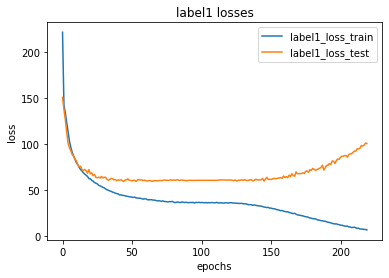

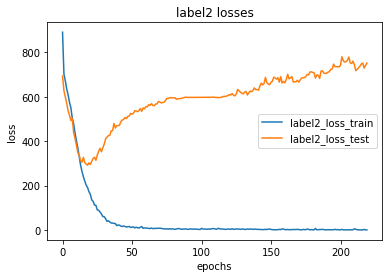

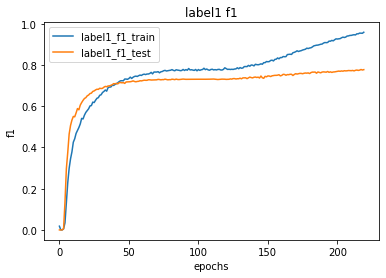

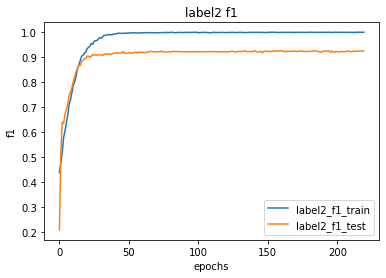

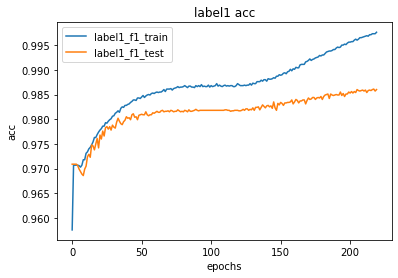

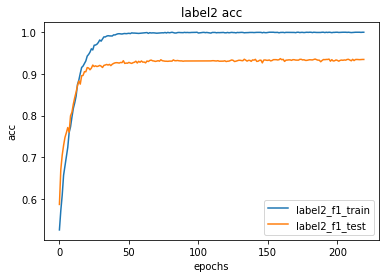

In [43]:
label1_loss_df.plot(title="label1 losses",xlabel="epochs",ylabel="loss")
label2_loss_df.plot(title="label2 losses",xlabel="epochs",ylabel="loss")
label1_f1_df.plot(title="label1 f1",xlabel="epochs",ylabel="f1")
label2_f1_df.plot(title="label2 f1",xlabel="epochs",ylabel="f1")
label1_acc_df.plot(title="label1 acc",xlabel="epochs",ylabel="acc")
label2_acc_df.plot(title="label2 acc",xlabel="epochs",ylabel="acc")

In [44]:
max(label2_f1_test_list)

0.9272

In [45]:
max(label2_acc_test_list)

0.9367

In [46]:
model.load_state_dict(torch.load(output_dir_test))


<All keys matched successfully>

In [47]:
print(output_dir_test)

./checkpoint\bert-large-uncased\test/checkpoint_epoch159.pt


In [48]:
loss_label1_te, loss_label2_te, p_label1_te, r_label1_te, f_label1_te, acc_label1_te, p_label2_te, r_label2_te, f_label2_te, acc_label2_te, comparison_df_te = evaluate_output_difference(model, test_iterator, criterion_tag, criterion_cls, TAG_PAD_IDX)

tp:  1604
fn:  146
tn:  2128
fp:  106
pred label2 length:  3984
true label2 length:  3984
token_idx_list length:  3984


C:\Users\Ruicheng\AppData\Local\Temp\ipykernel_4400\3303094034.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append(df2, ignore_index = True)
C:\Users\Ruicheng\AppData\Local\Temp\ipykernel_4400\3303094034.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append(df2, ignore_index = True)
C:\Users\Ruicheng\AppData\Local\Temp\ipykernel_4400\3303094034.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append(df2, ignore_index = True)
C:\Users\Ruicheng\AppData\Local\Temp\ipykernel_4400\3303094034.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat in

match number:  3732


C:\Users\Ruicheng\AppData\Local\Temp\ipykernel_4400\3303094034.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append(df2, ignore_index = True)
C:\Users\Ruicheng\AppData\Local\Temp\ipykernel_4400\3303094034.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append(df2, ignore_index = True)
C:\Users\Ruicheng\AppData\Local\Temp\ipykernel_4400\3303094034.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append(df2, ignore_index = True)
C:\Users\Ruicheng\AppData\Local\Temp\ipykernel_4400\3303094034.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat in

In [49]:
f_label2_te

0.9272

In [50]:
acc_label2_te

0.9367

In [51]:
test_data_female = data.TabularDataset(
                                    path = DATA_PATH+'gap_test_female_bert_2mask.csv',
                                    format = 'csv',
                                    fields = fields,
                                    skip_header = True)
test_data_male = data.TabularDataset(
                                    path = DATA_PATH+'gap_test_male_bert_2mask.csv',
                                    format = 'csv',
                                    fields = fields,
                                    skip_header = True)

TOKEN.build_vocab(test_data_female, test_data_male)
LABEL1.build_vocab(test_data_female, test_data_male)
FT_TAGS.build_vocab(test_data_female, test_data_male)
SEQ.build_vocab(test_data_female, test_data_male)
LABEL2.build_vocab(test_data_female, test_data_male)

In [52]:
print(test_data_female)
print(test_data_male)

In [53]:
test_female_iterator = data.BucketIterator(
    test_data_female, 
    batch_size = BATCH_SIZE,
    device = device,
    shuffle = True,
    sort=False)
test_male_iterator = data.BucketIterator(
    test_data_male, 
    batch_size = BATCH_SIZE,
    device = device,
    shuffle = True,
    sort=False)

In [54]:
print(type(test_female_iterator))
print(type(test_male_iterator))

<class 'torchtext.legacy.data.iterator.BucketIterator'>
<class 'torchtext.legacy.data.iterator.BucketIterator'>


In [55]:
loss_label1_te_female, loss_label2_te_female, p_label1_te_female, r_label1_te_female,f_label1_te_female, acc_label1_te_female, p_label2_te_female,r_label2_te_female, f_label2_te_female, acc_label2_te_female = evaluate(model, test_female_iterator, criterion_tag, criterion_cls, TAG_PAD_IDX)

tp:  792
fn:  78
tn:  1066
fp:  58
pred label2 length:  1994
true label2 length:  1994
match number:  1858


In [56]:
f_label2_te_female

0.9209

In [57]:
loss_label1_te_male, loss_label2_te_male, p_label1_te_male, r_label1_te_male, f_label1_te_male, acc_label1_te_male, p_label2_te_male, r_label2_te_male, f_label2_te_male, acc_label2_te_male = evaluate(model, test_male_iterator, criterion_tag, criterion_cls, TAG_PAD_IDX)

tp:  808
fn:  72
tn:  1057
fp:  53
pred label2 length:  1990
true label2 length:  1990
match number:  1865


In [58]:
f_label2_te_male

0.9282

In [59]:
Bias=f_label2_te_female/f_label2_te_male

In [60]:
Bias

0.9921353156647275

In [61]:
#os.chdir('E:/Google Drive/Continental/coref-multitask/winogender')
os.chdir('./gap')
comparison_df_te.to_csv("comparison_gap_bert_multitask_lbwb_gap.csv", index=False,encoding='utf-8-sig')

In [62]:
# os.chdir('E:/Google Drive/Continental/coref-multitask')
# DATA_PATH = './winogender/'
# winogender_df = data.TabularDataset(
#                                     path = DATA_PATH+'winogender_df_new_spanbert.csv',
#                                     format = 'csv',
#                                     fields = fields,
#                                     skip_header = True)

# TOKEN.build_vocab(winogender_df)
# LABEL1.build_vocab(winogender_df)
# FT_TAGS.build_vocab(winogender_df)
# SEQ.build_vocab(winogender_df)
# LABEL2.build_vocab(winogender_df)

In [63]:
# print(winogender_df)

In [64]:
# winogender_iterator = data.BucketIterator(
#     winogender_df, 
#     batch_size = BATCH_SIZE,
#     device = device,
#     shuffle = True,
#     sort=False)

In [65]:
# loss_label1_winogender, loss_label2_winogender, p_label1_winogender, r_label1_winogender,f_label1_winogender, acc_label1_winogender, p_label2_winogender,r_label2_winogender, f_label2_winogender, acc_label2_winogender = evaluate(model, winogender_iterator, criterion_tag, criterion_cls, TAG_PAD_IDX)

In [66]:
# acc_label2_winogender